# Slave Migration Lab

In 1793(?) Eli Whitney patented an invention with enormous consequences:
<img src="eli-whitney-cotton-gin.jpg" width=250>
source: "http://mtviewmirror.com/eli-whitney-inventor-of-the-cotton-gin/"

Textile production drove the early Industrial Revolution, but by the early 19th Century, the need for cotton was growing much faster than the supply.  The reason was that "short staple" cotton -- the easiest kind of cotton to grow was not commercially viable because separating the seeds from the fluffy part was too tedious even for slave labor.

Whitney's cotton gin changed that and as a result, by 1860 the American South below the 37th paralell came to supply over 80% of Britain's remarkable demand for Cotton.

In [2]:
# Run this cell, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *
#from datascience.predicates import are
# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
from datascience.predicates import are

In [4]:
slaves1850=Table.read_table("ICPSR-LabDataSlavesByAgeSex1850-long.csv")
slaves1860=Table.read_table("ICPSR-LabDataSlavesByAgeSex1860-long.csv")

In [5]:
slaves1860.show(5)


DATA.TYPE,YEAR,ICPR.STATE.CODE,STATE.NAME,variable,value
S,860,1,CONNECTICUT,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,2,MAINE,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,3,MASSACHUSETTS,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,4,NEW HAMPSHIRE,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,5,RHODE ISLAND,X860SLAVE.FEMALES.00.01.UNDER.1.,nan


In [6]:
slaves1850.relabel('variable','agesex')
slaves1850.relabel('value','N')
slaves1860.relabel('variable','agesex')
slaves1860.relabel('value','N')

DATA.TYPE,YEAR,ICPR.STATE.CODE,STATE.NAME,agesex,N
S,860,1,CONNECTICUT,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,2,MAINE,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,3,MASSACHUSETTS,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,4,NEW HAMPSHIRE,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,5,RHODE ISLAND,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,6,VERMONT,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,11,DELAWARE,X860SLAVE.FEMALES.00.01.UNDER.1.,28
S,860,12,NEW JERSEY,X860SLAVE.FEMALES.00.01.UNDER.1.,0
S,860,13,NEW YORK,X860SLAVE.FEMALES.00.01.UNDER.1.,nan
S,860,14,PENNSYLVANIA,X860SLAVE.FEMALES.00.01.UNDER.1.,nan


What's up with 'nan' ?  

Why do you think New York's "X860SLAVE.FEMALES.00.01.UNDER.1." are reported as 'nan'  while those of New Jersey
are reported as 0 ?

Yes google knows the answer, but thinking before googling is good for your soul.

In [7]:
## Let's lose the virtuous -- but non interesting states that have no saves
slaves1850=slaves1850.where(slaves1850['N'] >=0)
slaves1860=slaves1860.where(slaves1860['N'] >=0)



In [8]:
# As a sanity check,  let's verify:
## that each state in our dataset has a non-nan entry for each age group -- ie let's verify
## that the set of recrods for each state.name is the same size


s50test=slaves1850.select(['STATE.NAME','N']).where(slaves1850['N'] >=0).group('STATE.NAME', collect= len)
s60test=slaves1860.select(['STATE.NAME','N']).where(slaves1860['N'] >=0).group('STATE.NAME', collect= len)

s50test.sort('STATE.NAME').show()
s60test.sort('STATE.NAME').show()

## Should s60test ans s50test have the same number of rows?
## what are the implications of different number of rows.
print("Hmmmm the 1850 table has ",s50test.num_rows, "rows")
print("And the 1860 table has", s60test.num_rows, "rows")
print("WHAT COULD THIS MEAN?")


STATE.NAME,N len
ALABAMA,32
ARKANSAS,32
DELAWARE,32
FLORIDA,32
GEORGIA,32
KENTUCKY,32
LOUISIANA,32
MARYLAND,32
MISSISSIPPI,32
MISSOURI,32


STATE.NAME,N len
ALABAMA,32
ARKANSAS,32
DELAWARE,32
FLORIDA,32
GEORGIA,32
KANSAS,32
KENTUCKY,32
LOUISIANA,32
MARYLAND,32
MISSISSIPPI,32


Hmmmm the 1850 table has  16 rows
And the 1860 table has 18 rows
WHAT COULD THIS MEAN?


That's kind of surprising isn't it?  Let's compare the set of slave states in 1850 with that of 1860
It turns out that python has a pretty convienient tool for doing this

In [9]:
## In python a 'set' contain objects whose memebership status can be compared with other sets
##  setA & setB  gives the intersection of setA and setB
## setA - setB gives the disjunction (the stuff in setA that is not in setB)
ss50=set(s50test.column('STATE.NAME'))
ss60=set(s60test.column('STATE.NAME'))
print("Here are the states that have slaves in 1850 AND a860")
print(ss50 & ss60)
print()
print("Here are the states that have slaves in 1850 but NOT in 1860")
print(ss50 - ss60)
print("Here are the states that have slaves in 1860 BUT did NOT in 1850")
print(ss60 - ss50)


Here are the states that have slaves in 1850 AND a860
{'LOUISIANA', 'NORTH CAROLINA', 'MISSISSIPPI', 'GEORGIA', 'KENTUCKY', 'ARKANSAS', 'MARYLAND', 'VIRGINIA', 'FLORIDA', 'ALABAMA', 'NEW JERSEY', 'TEXAS', 'TENNESSEE', 'MISSOURI', 'DELAWARE', 'SOUTH CAROLINA'}

Here are the states that have slaves in 1850 but NOT in 1860
set()
Here are the states that have slaves in 1860 BUT did NOT in 1850
{'KANSAS', 'NEBRASKA'}


This would be a good time to Google Compromise of 1850; Kansas-Nebraska Act; and Dred Scott Decision

Now let's clean up the original data tables (slaves1850 and slaves1860) so that we can estimate slave mortality/survival rates... and eventually the numbers of slaves by age and sex who migrated into and out of each state.

The steps we'll take to accomplish this are:
<ol>
<li> Clean up the agesex variable they are not the same in 1850 and 1860
<li> Create columns of numbers that reflect the age categories embedded in the agesex variable
</ol>
For this we will need to use some string functions:
<ul>
<li> x.split('.') -- which converts a sring, x, into a list by splitting at each instance of '.'
<li> x.find('boo') -- which reports the index of the 'b' within the string x.
<li> 'y' in L  -- which reports whether or not the  'y' is an element of list L
</ul>

In [10]:
## It turns out that the agesex variable is not easily comparable across 1850 and 1860. This sort of thing is 
## quite common in science -- but it really sucks.
slaves1850.where(slaves1850['STATE.NAME'] == "VIRGINIA").select('agesex').show()
slaves1860.where(slaves1860['STATE.NAME'] == "VIRGINIA").select('agesex').show()


agesex
X850SLAVE.FEMALES.00.01.UNDER.01.
X850SLAVE.FEMALES.01.04
X850SLAVE.FEMALES.05.09
X850SLAVE.FEMALES.10.14
X850SLAVE.FEMALES.15.19
X850SLAVE.FEMALES.20.29
X850SLAVE.FEMALES.30.39
X850SLAVE.FEMALES.40.49
X850SLAVE.FEMALES.50.59
X850SLAVE.FEMALES.60.69


agesex
X860SLAVE.FEMALES.00.01.UNDER.1.
X860SLAVE.FEMALES.01.04
X860SLAVE.FEMALES.05.09
X860SLAVE.FEMALES.10.14
X860SLAVE.FEMALES.15.19
X860SLAVE.FEMALES.20.29
X860SLAVE.FEMALES.30.39
X860SLAVE.FEMALES.40.49
X860SLAVE.FEMALES.50.59
X860SLAVE.FEMALES.60.69


In [11]:
## STEP 1 is to clean up the 'agesex' variable so that we can: (1) delete the TOTAL and UNKNOWN AGE rows
## and (2) create numerical columns that identify the age categories

## There are some annoying differences and irregularities in the agesex column. We'll fix it by writing a function
## that we'll call "improve" which we will use with .apply() and .append_column()  -- this is 
## a construction that we'll probably use a lot this semester
def improve (x) :
    ## a function that rationalizes the agesex column in the ICPSR slaves data
    ## it is designed to be used with .apply()
    res=x.replace('.AGE.UKWN','UNKNOWN')\
    .replace('.AGE.UNKW','UNKNOWN')\
    .replace('X850SLAVE.','')\
    .replace('X860SLAVE.','') \
    .replace('X850TOTAL.SLAVE.','TOTAL')\
    .replace('X860TOT.SLAVE.','TOTAL')\
    .replace('.UNDER.1.','')\
    .replace('.UNDER.01.','')\
    .replace('AND.OVER','110')
    return(res)

## test the imporve function on one state's worth of data
virginia=slaves1850.where(slaves1850['STATE.NAME'] == "VIRGINIA")   

Table().with_columns(['new',virginia.apply(improve,['agesex']),
                     'old',virginia.column('agesex')]).show(5)

## OK lets do it for slaves18X0
slaves1850.append_column('agesex',slaves1850.apply(improve,['agesex']))
slaves1860.append_column('agesex',slaves1860.apply(improve,['agesex']))
slaves1860.show(10)

## Now pull out the total and unknown rows
totals1850= slaves1850.where([ 'TOTAL' in f for f in slaves1850.column('agesex') ])
unknows1850=slaves1850.where(['UNKNOWN' in f for f in slaves1850.column('agesex') ])
totals1860= slaves1860.where([ 'TOTAL' in f for f in slaves1860.column('agesex') ])
unknows1860=slaves1860.where(['UNKNOWN' in f for f in slaves1860.column('agesex') ])
print("TOTAL rows 1850:",totals1850.num_rows," 1860:", totals1860.num_rows)
print("UNKNOWN rows 1850: ", unknows1850.num_rows," 1860:", unknows1860.num_rows)
## remove TOTAL and UNKNOWN rows from slaves18X0 tables
slaves1850=slaves1850.where( ['TOTAL' not in f and 'UNKNOWN' not in f for f in slaves1850.column('agesex')])
slaves1860=slaves1860.where( ['TOTAL' not in f and 'UNKNOWN' not in f for f in slaves1860.column('agesex')])
print("rows known age slaves1850 :", slaves1850.num_rows, "1860: ", slaves1860.num_rows)
## Heads up.  slaves18x0 tables change.  Do not run again without executing all cells above


new,old
FEMALES.00.01,X850SLAVE.FEMALES.00.01.UNDER.01.
FEMALES.01.04,X850SLAVE.FEMALES.01.04
FEMALES.05.09,X850SLAVE.FEMALES.05.09
FEMALES.10.14,X850SLAVE.FEMALES.10.14
FEMALES.15.19,X850SLAVE.FEMALES.15.19


DATA.TYPE,YEAR,ICPR.STATE.CODE,STATE.NAME,agesex,N
S,860,11,DELAWARE,FEMALES.00.01,28
S,860,12,NEW JERSEY,FEMALES.00.01,0
S,860,32,KANSAS,FEMALES.00.01,0
S,860,34,MISSOURI,FEMALES.00.01,1805
S,860,35,NEBRASKA,FEMALES.00.01,0
S,860,40,VIRGINIA,FEMALES.00.01,7079
S,860,41,ALABAMA,FEMALES.00.01,6400
S,860,42,ARKANSAS,FEMALES.00.01,1743
S,860,43,FLORIDA,FEMALES.00.01,883
S,860,44,GEORGIA,FEMALES.00.01,7137


TOTAL rows 1850: 32  1860: 36
UNKNOWN rows 1850:  32  1860: 36
rows known age slaves1850 : 448 1860:  504


In [12]:
## a sanity check:  do all the age specified rows plus the Unknown rows add up to the total row
##
print("1860 Slave population data sanity check MALES")

m60_k=slaves1860.where(['FEMALE' not in f for f in slaves1860.column('agesex')]).\
group('STATE.NAME', sum).relabel('N sum','N known').select(['STATE.NAME','N known'])

m60_t=totals1860.where(['FEMALE' not in f for f in totals1860.column('agesex')]).\
relabel('N','N tot').select(['STATE.NAME','N tot'])

m60_u=unknows1860.where(['FEMALE' not in f for f in unknows1860.column('agesex')]).\
relabel('N', 'N unk').select(['STATE.NAME','N unk'])

m60=m60_k.join('STATE.NAME',m60_u).join('STATE.NAME',m60_t)
m60.append_column('dif',m60.apply(lambda k,u,t : (k+u-t),['N known','N unk','N tot']))
m60.show()

#### Females
print("1860 Slave population data sanity check FEMALES")
f60_k=slaves1860.where(['FEMALE'  in f for f in slaves1860.column('agesex')]).\
group('STATE.NAME', sum).relabel('N sum','N known').select(['STATE.NAME','N known'])

f60_t=totals1860.where(['FEMALE'  in f for f in totals1860.column('agesex')]).\
relabel('N','N tot').select(['STATE.NAME','N tot'])

f60_u=unknows1860.where(['FEMALE'  in f for f in unknows1860.column('agesex')]).\
relabel('N', 'N unk').select(['STATE.NAME','N unk'])

f60=f60_k.join('STATE.NAME',f60_u).join('STATE.NAME',f60_t)
f60.append_column('dif',f60.apply(lambda k,u,t : (k+u-t),['N known','N unk','N tot']))
f60.show()

## Perhaps you would care to do this yourself for 1850


1860 Slave population data sanity check MALES


STATE.NAME,N known,N unk,N tot,dif
ALABAMA,217764,2,217766,0
ARKANSAS,56172,2,56174,0
DELAWARE,860,0,860,0
FLORIDA,31221,27,31348,-100
GEORGIA,229125,68,229193,0
KANSAS,0,0,0,0
KENTUCKY,112979,30,113009,0
LOUISIANA,169084,12,171977,-2881
MARYLAND,44313,0,44313,0
MISSISSIPPI,209297,80,219301,-9924


1860 Slave population data sanity check FEMALES


STATE.NAME,N known,N unk,N tot,dif
ALABAMA,217308,6,217314,0
ARKANSAS,54933,8,54941,0
DELAWARE,938,0,938,0
FLORIDA,30256,41,30397,-100
GEORGIA,232945,60,233005,0
KANSAS,2,0,2,0
KENTUCKY,112445,29,112474,0
LOUISIANA,157622,8,159749,-2119
MARYLAND,42876,0,42876,0
MISSISSIPPI,207929,84,217330,-9317


In [13]:
## So Mississippi wins a prize for a 4.5 % discrepency between the reported totals and the sum of the constituent
## parts ... kind of a drag for science isn't it ?
## Perhaps a look at the sex ratio at each age might reveal something suspicious:

mis=slaves1860.where(slaves1860.column('STATE.NAME') == 'MISSISSIPPI')
misF=mis.where(['FEMALE' in f for f in mis.column('agesex')])
misM=mis.where(['FEMALE' not in f for f in mis.column('agesex')])
misM['N']/misF['N']

array([ 0.90938829,  0.97342284,  0.98776717,  1.05081001,  0.94031966,
        1.02262848,  1.01430343,  1.05161787,  1.09020415,  1.15636178,
        1.01322751,  0.96358543,  1.15053763,  1.02439024])

In [14]:
def parseAge(x) :
    ## this uses split() to separate string into a list
    def intOrNan(z) :
        try :
            return (int(z))
        except :
            return (float('nan'))
    
    words=x.split('.')
    # return an python 'dictionary' object
    return({'sex': words[0],'loAge': intOrNan(words[1]), 'hiAge' : intOrNan(words[2])})

parsedSexAge=slaves1850.apply(parseAge,['agesex'])
slaves1850=slaves1850.with_columns([
    'sex',[f['sex'] for f in parsedSexAge],
    'loAge',[f['loAge'] for f in parsedSexAge],
    'hiAge',[f['hiAge'] for f in parsedSexAge]])
slaves1850.show(10)
## now do 1860
parsedSexAge=slaves1860.apply(parseAge,['agesex'])
slaves1860=slaves1860.with_columns([
    'sex',[f['sex'] for f in parsedSexAge],
    'loAge',[f['loAge'] for f in parsedSexAge],
    'hiAge',[f['hiAge'] for f in parsedSexAge]])
#slaves1860.show(10)

DATA.TYPE,YEAR,ICPR.STATE.CODE,STATE.NAME,agesex,N,sex,loAge,hiAge
S,850,11,DELAWARE,FEMALES.00.01,32,FEMALES,0,1
S,850,12,NEW JERSEY,FEMALES.00.01,0,FEMALES,0,1
S,850,34,MISSOURI,FEMALES.00.01,1334,FEMALES,0,1
S,850,40,VIRGINIA,FEMALES.00.01,5814,FEMALES,0,1
S,850,41,ALABAMA,FEMALES.00.01,4118,FEMALES,0,1
S,850,42,ARKANSAS,FEMALES.00.01,619,FEMALES,0,1
S,850,43,FLORIDA,FEMALES.00.01,451,FEMALES,0,1
S,850,44,GEORGIA,FEMALES.00.01,4889,FEMALES,0,1
S,850,45,LOUISIANA,FEMALES.00.01,2591,FEMALES,0,1
S,850,46,MISSISSIPPI,FEMALES.00.01,3788,FEMALES,0,1


In [15]:


print("slaves of known age 1850 ")
sum_1850=sum(slaves1850['N'])

print(sum_1850)
print("slaves of known age 1860 ")
sum_1860=sum(slaves1860['N'])
print(sum_1860)
print("percent increase 1850 - 1860")
print((sum_1860 -sum_1850)/sum_1850)
print("average annual growth rate")
import math
print(math.log(sum_1860/sum_1850) / 10)




slaves of known age 1850 
3196908.0
slaves of known age 1860 
3924460.0
percent increase 1850 - 1860
0.227579899077
average annual growth rate
0.020504466946637163


sex,loAge,hiAge,agesex,DATA.TYPE sum,YEAR sum,ICPR.STATE.CODE sum,STATE.NAME sum,N1860
FEMALES,0,1,FEMALES.00.01,,15480,726,,58360
FEMALES,1,4,FEMALES.01.04,,15480,726,,272489
FEMALES,5,9,FEMALES.05.09,,15480,726,,288449
FEMALES,10,14,FEMALES.10.14,,15480,726,,264002
FEMALES,15,19,FEMALES.15.19,,15480,726,,228178


agesex,sex,loAge,hiAge,N1850,N1860
FEMALES.00.01,FEMALES,0,1,41225,58360
FEMALES.01.04,FEMALES,1,4,231953,272489
FEMALES.05.09,FEMALES,5,9,239637,288449
FEMALES.10.14,FEMALES,10,14,214368,264002
FEMALES.15.19,FEMALES,15,19,180792,228178


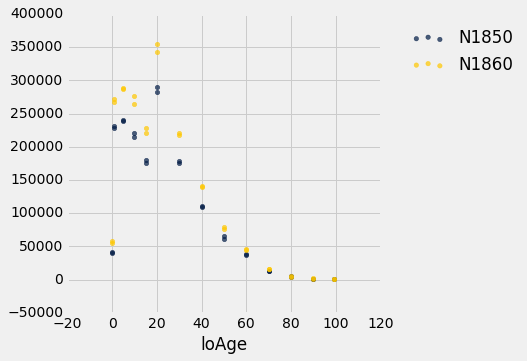

In [16]:
#slaves1850_allStates.where(slaves1850_allStates['sex'] == 'FEMALE').barh(column_for_categories='loAge',select='N sum')
#slaves1850_allStates.where(slaves1850_allStates['sex'] == 'FEMALE').scatter('loAge',select='N sum')
#slaves1850_allStates.where(slaves1850_allStates['sex'] == 'FEMALE').scatter('loAge',select='N sum')
#slaves1850_allStates=slaves1850.groups(['agesex','sex','loAge','hiAge'],sum)
#slaves1850_allStates.show()
spop1850=slaves1850.groups(['sex','loAge','hiAge','agesex'], sum).relabeled('N sum','N1850')
spop1860=slaves1860.groups(['sex','loAge','hiAge','agesex'], sum).relabeled('N sum','N1860')
spop1860.show(5)

spopByYear=spop1850.select(['agesex','sex','loAge','hiAge','N1850']).join('agesex',spop1860.select(['agesex','N1860']))
spopByYear.show(5)
spopByYear.scatter('loAge',select=['N1850','N1860'])
#spopByYear.show(10)

In [20]:
'N' in slaves1850.labels


True

Interesting scatter plot don't you think?

How many gold dots and how many blue dots are there for each age category? Is that right?

What is going on with age 20 (loAge = 20) why does it jump ?





So, you <i>might</i> remember that our goal in all this is to find a set
of mortality rates by age for US resident slaves between 1850 and 1860.

In order to do this, with the data at hand, we are going to have to make some
assumptions.  But let's start with a description of the process that I have in mind
and then decide what sort assumption we'll need to make and discuss whether or not
we can live with them

Let's divide the number of US resident enslaved people of each sex who were of age $X$ in 1860
by the number of US resident enslaved people of the same sex but of age $X-10$ in 1850

If we let $N_{x,t}$ be the number of US resident slaves of age $x$ in year $t$ then the quantity I am proposing
to consider is:

$S_{x}=\frac{N_{x,1860}}{N_{x-10,1850}}$

QUESTION:  What assumptions do we need to make in order to assert that $S_{x}$ is the 'true' survival rate ?




How to calculate $S_x$:


midAge10,agesex,sex,loAge,hiAge,N1850,N1860,midAge,loAge_2,hiAge_2,N1850_2,N1860_2,midAge10_2,surv5060
12,FEMALES.0.4,FEMALES,0,4,273178,330849,2,10,14,214368,264002,22,0.96641
17,FEMALES.05.09,FEMALES,5,9,239637,288449,7,15,19,180792,228178,27,0.952182
24.5,FEMALES.10.19,FEMALES,10,19,395160,492180,14.5,20,29,282186,342680,34.5,0.867193
34.5,FEMALES.20.29,FEMALES,20,29,282186,342680,24.5,30,39,178110,220299,44.5,0.780687
44.5,FEMALES.30.39,FEMALES,30,39,178110,220299,34.5,40,49,110598,138824,54.5,0.779428
54.5,FEMALES.40.49,FEMALES,40,49,110598,138824,44.5,50,59,61632,75789,64.5,0.685266
64.5,FEMALES.50.59,FEMALES,50,59,61632,75789,54.5,60,69,36499,44044,74.5,0.714629
74.5,FEMALES.60.69,FEMALES,60,69,36499,44044,64.5,70,79,13659,15694,84.5,0.429984
84.5,FEMALES.70.79,FEMALES,70,79,13659,15694,74.5,80,89,4732,5323,94.5,0.389706
94.5,FEMALES.80.89,FEMALES,80,89,4732,5323,84.5,90,99,1470,1714,104.5,0.362215


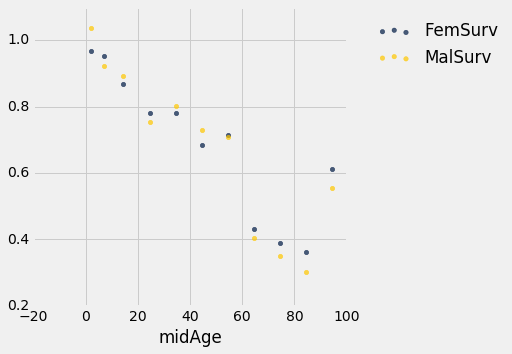

In [51]:
## OK Let's proceed.  Because we are going to want to do this a couple of times...
## let's create a function that takes as inputs tables of counts of slaves by age in 1850 and 1860
## and returns a table that contains all the input information + a column the survival rate discussed above


def getSurv (spop1850,spop1860) :
    ## expects two tables one of slave counts by age in 1850 and the other in 1860
    ## returns one table with all the input tables joined + a column of survival rates by age
    ## NOTE spop18X0 is NOT slaves18X0 spop18x0 must have only ONE row for each age group
    def combineYears(spop5,spop6) :
        ## combine spop1850 and spop1860 into one table with N1850 and N1860 columns
        for lab in ['N', 'N sum'] :
            if lab in spop5.labels :
                spop5.relabel(lab,'N1850')
            if lab in spop6.labels :
                spop6.relabel(lab,'N1860')
        spop2years=spop5.select(['agesex','sex','loAge','hiAge','N1850']).join('agesex',spop6.select(['agesex','N1860']))
        return(spop2years)
                                                                                                                                                             
        
    def combineAges(spop):
        ## given a table of counts of slaves by age ... returns same table with additional rows
        ## created by adding together ages 0 and 1..4   AND ages 10-14 with 15-19
        ## the resulting table will have OVERLAPPING AGES       
        
        # extract age 0 and 1-4 for each state and sum the Ns
        temp=spop.where(spop.column('loAge')<= 1).groups(['sex'],sum)
        # extract 10-14 and 15-19 for each state and sum the Ns
        temp2=spop.where(spop.column('loAge'), are.between_or_equal_to(10,15)).groups(['sex'],sum)
        ## correct the loAge and hiAge  which were also summed in the previous operation
        temp.append_column('loAge sum',0)
        temp.append_column('hiAge sum',4)
        temp2.append_column('loAge sum',10)
        temp2.append_column('hiAge sum',19)
        ## combine temp and temp2
        temp=temp.with_rows(temp2.to_array())
        ## change columnnames of temp
        temp.relabel('loAge sum','loAge')
        temp.relabel('hiAge sum','hiAge')
        temp.relabel('N1850 sum','N1850')
        temp.relabel('N1860 sum', 'N1860')
        temp.append_column('agesex sum',['FEMALES.0.4','MALES.0.4','FEMALES.10.19','MALES.10.19'])
        temp.relabel('agesex sum','agesex')
       
        ## add rows in temp to original table spop
        res=spop.where(spop.column('loAge') >1).with_rows( \
        temp.select(['agesex','sex','loAge','hiAge','N1850','N1860']).to_array())
        return(res)
    
    def addMidageCols(spop) :
        ## midage and midage10 columns to table where midage is midpoint between loAge and hiAge
        ## and midage10 is midage+10.
        ## these will be used in clever join command later
        spop.append_column('midAge',spop.apply(lambda hi, lo :(lo+hi)/2, ['loAge','hiAge']))
        spop.append_column('midAge10',spop.apply(lambda mid : (mid+10), ['midAge']))
        return(spop)
    
    ## use the functions defined above and calculate the survival rate
    spop=combineYears(spop1850,spop1860)
    spop=combineAges(spop)
    spop=addMidageCols(spop)
    #  separate males and females b/c joins only work on a single variable
    males=spop.where(spop['sex'] == 'MALES')
    females=spop.where(spop['sex'] == 'FEMALES')
    #  join with self (very clever) matching midAge and midAge10 !
    males=males.join('midAge10',males,'midAge')
    females=females.join('midAge10',females,'midAge')
    # and the suvival rate calculation
    males.append_column('surv5060',males.apply(lambda n1850,n1860:(n1860/n1850), ['N1850','N1860_2']))
    females.append_column('surv5060',females.apply(lambda n1850,n1860:(n1860/n1850), ['N1850','N1860_2']))

    res=females.append(males)

    return(res.sort('midAge').sort('sex'))

#################################################################
## Now let's test  the function  and draw a scatter
################################################################
s50=slaves1850.groups(['loAge','hiAge','sex','agesex'], sum)
s60=slaves1860.groups(['loAge','hiAge','sex','agesex'], sum)

slaveSurv=getSurv(s50,s60)
slaveSurv.to_csv("SlaveSurvivalRates1850_60.csv")
slaveSurv.drop(['agesex_2','sex_2']).show()
fSurv=slaveSurv.where(slaveSurv.column('sex') == 'FEMALES')
mSurv=slaveSurv.where(slaveSurv.column('sex') == 'MALES')
## plot male and female survival rates against midAge
fSurv.select(['midAge','surv5060']).join('midAge',mSurv.select(['midAge','surv5060'])).relabel('surv5060','FemSurv').\
relabel('surv5060_2','MalSurv').scatter('midAge',select=['FemSurv','MalSurv'])
    


Now we should probably digress a bit on these survival curves and construct
a life table then compare it to some other contemporary and perhaps Swedish
tables ?

Might I leave it this point for the students to find "Expected Populations" of Virginia 1860
and then subtract to find the migrating population

In [30]:


### OBSOLETE   now embedded in function above

### OK Let's proceed. In order to calculate the survival rates defined above, we are going
## to have to combine a few age categories so that we will be able to compare them with their
## corresponding quantities 10 years later. 

# For example,  we have age 0 and 1-4  ... and then we have age 10-14  If we have age 10  and 11-14 all would be great
# but we do not so we'll have to combine 1 and 1-4.  A process which turns out to be kind of tedious with our 
# current tool set.

# extract age 0 and 1-4 for each state and sum the Ns
temp=spopByYear.where(spopByYear.column('loAge')<= 1).groups(['sex'],sum)
# extract 10-14 and 15-19 for each state and sum the Ns
temp2=spopByYear.where(spopByYear.column('loAge'), are.between_or_equal_to(10,15)).groups(['sex'],sum)

temp.show()
temp2.show()
## correct the loAge and hiAge  which were also summed in the previous operation
temp.append_column('loAge sum',0)
temp.append_column('hiAge sum',4)
temp2.append_column('loAge sum',10)
temp2.append_column('hiAge sum',19)
## combine temp and temp2
temp=temp.with_rows(temp2.to_array())
## change columnnames of temp
temp.relabel('loAge sum','loAge')
temp.relabel('hiAge sum','hiAge')
temp.relabel('N1850 sum','N1850')
temp.relabel('N1860 sum', 'N1860')
temp.append_column('agesex sum',['FEMALES.0.4','MALES.0.4','FEMALES.10.19','MALES.10.19'])
temp.relabel('agesex sum','agesex')
temp.show()
spopByYearx=spopByYear.where(spopByYear.column('loAge') >1).with_rows(
    temp.select(['agesex','sex','loAge','hiAge','N1850','N1860']).to_array())


spopByYearx.append_column('midAge',spopByYearx.apply(lambda hi, lo :(lo+hi)/2, ['loAge','hiAge']))

spopByYearx.sort('loAge')
print('NOTICE that our age categories are NO LONGER NON-OVERLAPPING')

sex,agesex sum,loAge sum,hiAge sum,N1850 sum,N1860 sum
FEMALES,,1,5,273178,330849
MALES,,1,5,266891,321961


sex,agesex sum,loAge sum,hiAge sum,N1850 sum,N1860 sum
FEMALES,,25,33,395160,492180
MALES,,25,33,397201,496930


sex,agesex,loAge,hiAge,N1850,N1860
FEMALES,FEMALES.0.4,0,4,273178,330849
MALES,MALES.0.4,0,4,266891,321961
FEMALES,FEMALES.10.19,10,19,395160,492180
MALES,MALES.10.19,10,19,397201,496930


NOTICE that our age categories are NO LONGER NON-OVERLAPPING


In [34]:
## now the magic part: getting mortality rates out of spopByYearx
## first trick add a mid point of the age range
spopByYearx.append_column('midAge',spopByYearx.apply(lambda hi,lo : (hi+lo)/2, ['hiAge','loAge']))
## and add another variable that is 10 more than the midpoint of the age range
spopByYearx.append_column('midAge10',spopByYearx.apply(lambda mid : (mid+10), ['midAge']))
spopByYearx.show(5)

males5060=spopByYearx.where(spopByYearx['sex'] == 'MALES')
females5060=spopByYearx.where(spopByYearx['sex'] == 'FEMALES')

males5060=males5060.join('midAge10',males5060,'midAge' )
females5060=females5060.join('midAge10',females5060,'midAge' )

## and here is where we get the survival rates
males5060.append_column('surv5060',males5060.apply(lambda n1850, n1860 : (n1860/n1850) , ['N1850','N1860_2']))
print("Male survival rates for slaves in the US 1850-60")
males5060.select(['agesex','agesex_2','N1850','N1860','N1860','N1860_2','surv5060']).show()

females5060.append_column('surv5060',females5060.apply(lambda n1850, n1860 : (n1860/n1850) , ['N1850','N1860_2']))
print("Female survival rates for slaves in the US 1850-60")

females5060.select(['agesex','agesex_2','N1850','N1860','N1860','N1860_2','surv5060']).show()
      
  

agesex,sex,loAge,hiAge,N1850,N1860,midAge,midAge10
FEMALES.05.09,FEMALES,5,9,239637,288449,7,17
FEMALES.10.14,FEMALES,10,14,214368,264002,12,22
FEMALES.15.19,FEMALES,15,19,180792,228178,17,27
FEMALES.20.29,FEMALES,20,29,282186,342680,24.5,34.5
FEMALES.30.39,FEMALES,30,39,178110,220299,34.5,44.5


Male survival rates for slaves in the US 1850-60


agesex,agesex_2,N1850,N1860,N1860_2,surv5060
MALES.0.4,MALES.10.14,266891,321961,276715,1.03681
MALES.05.09,MALES.15.19,238953,287135,220215,0.921583
MALES.10.19,MALES.20.29,397201,496930,354818,0.893296
MALES.20.29,MALES.30.39,289354,354818,218234,0.754211
MALES.30.39,MALES.40.49,175171,218234,140706,0.803249
MALES.40.49,MALES.50.59,109060,140706,79720,0.730974
MALES.50.59,MALES.60.69,65198,79720,46189,0.708442
MALES.60.69,MALES.70.79,38058,46189,15415,0.40504
MALES.70.79,MALES.80.89,13154,15415,4620,0.351224
MALES.80.89,MALES.90.99,4374,4620,1317,0.301097


Female survival rates for slaves in the US 1850-60


agesex,agesex_2,N1850,N1860,N1860_2,surv5060
FEMALES.0.4,FEMALES.10.14,273178,330849,264002,0.96641
FEMALES.05.09,FEMALES.15.19,239637,288449,228178,0.952182
FEMALES.10.19,FEMALES.20.29,395160,492180,342680,0.867193
FEMALES.20.29,FEMALES.30.39,282186,342680,220299,0.780687
FEMALES.30.39,FEMALES.40.49,178110,220299,138824,0.779428
FEMALES.40.49,FEMALES.50.59,110598,138824,75789,0.685266
FEMALES.50.59,FEMALES.60.69,61632,75789,44044,0.714629
FEMALES.60.69,FEMALES.70.79,36499,44044,15694,0.429984
FEMALES.70.79,FEMALES.80.89,13659,15694,5323,0.389706
FEMALES.80.89,FEMALES.90.99,4732,5323,1714,0.362215


<img src="http://images.slideplayer.com/13/3828559/slides/slide_4.jpg">


https://www.google.com/url?sa=i&rct=j&q=&esrc=s&source=images&cd=&cad=rja&uact=8&ved=0ahUKEwij5unfl7rNAhVT2GMKHYGKAaEQjRwIBw&url=http%3A%2F%2Fslideplayer.com%2Fslide%2F3828559%2F&psig=AFQjCNHZaJXmI6Ww060hSrcu3wo6L9D9kw&ust=1466635127084012